# Context
The dataset comes from Kaggle https://inclass.kaggle.com/jordangoblet/atp-tour-20002016, and has been compiled from various sources.

It contains relatively high level data about all tennis games on the ATP tour, like the date of the game, names of both players, who won, their ranks, the type of surface, the name of the tournament...

There is some other data (which I don't think I"ll use) such as:
* The breakdown of the scores eg 6-4 6-4 6-4
* Various betting odds from various betting companies

To recap:
* we're trying to predict who will win a given tennis match, based on the information available. We will have to compute derived features that represent the user's past performance, as the information available upfront for a given tennis match is relatively limited
* A baseline could be based on the current ATP ranking (ie the better ranked player should win)

In [590]:
QUICK_MODE = True  # Only model for a subset of the players (for quicker computations)

# 1/ Basic look at the data + Cleaning data (converting types and removing NAs)

In [591]:
import pandas as pd, numpy as np
import importlib
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,8)

In [592]:
# Importing my helper module
from tennis_predictor import clean_data

In [593]:
df = pd.read_csv("data.csv", low_memory=False)
COLUMNS = [
    "Location", "Tournament", "Date",
    "Series",
    "Court", "Surface",
    "Round", "Best of",
    "Winner", "Loser", "WRank", "LRank",
]
GAME_STATS_COLS = [
    "W1", "L1", "W2", "L2", "W3", "L3", "W4", "L4", "W5", "L5",
    "Wsets", "Lsets"
]
df = df[COLUMNS + GAME_STATS_COLS]

## 1.A An example record

In [594]:
# Example record
df.iloc[377]

Location                 Memphis
Tournament       Kroger St. Jude
Date                  14/02/2000
Series        International Gold
Court                     Indoor
Surface                     Hard
Round                  1st Round
Best of                        3
Winner                 Mamiit C.
Loser                  Jensen L.
WRank                        135
LRank                         NR
W1                             7
L1                             5
W2                             6
L2                             2
W3                           NaN
L3                           NaN
W4                           NaN
L4                           NaN
W5                           NaN
L5                           NaN
Wsets                          2
Lsets                          0
Name: 377, dtype: object

## 1.B Converting to the appropriate data types, dropping rows with NAs

In [595]:
data = clean_data.convert_to_numeric(df, ["WRank", "LRank"])
data = data.assign(
    Date=pd.to_datetime(data.Date, format="%d/%m/%Y")
)
data = clean_data.drop_nas(data, COLUMNS)  # This will also print a summary of where we had NAs

Location       0
Tournament     0
Date           0
Series         0
Court          0
Surface        0
Round          0
Best of        0
Winner         0
Loser          0
WRank         16
LRank         98
dtype: int64


## 1.C Inspecting the data

In [562]:
data.iloc[:,:20].head()

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63.0,77.0,6.0,4.0,6.0,2.0,NaN,NaN,NaN,NaN
1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,5.0,56.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN
2,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,40.0,655.0,6.0,7.0,7.0,5.0,6.0,3.0,NaN,NaN
3,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,Knippschild J.,65.0,87.0,6.0,1.0,6.0,4.0,NaN,NaN,NaN,NaN
4,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,81.0,198.0,7.0,6.0,5.0,7.0,6.0,4.0,NaN,NaN


In [563]:
data.iloc[:,20:].head()

,W5,L5,Wsets,Lsets
0,NaN,NaN,2.0,0.0
1,NaN,NaN,2.0,0.0
2,NaN,NaN,2.0,1.0
3,NaN,NaN,2.0,0.0
4,NaN,NaN,2.0,1.0


In [565]:
data.dtypes, data.shape

(Location              object
 Tournament            object
 Date          datetime64[ns]
 Series                object
 Court                 object
 Surface               object
 Round                 object
 Best of                int64
 Winner                object
 Loser                 object
 WRank                float64
 LRank                float64
 W1                   float64
 L1                   float64
 W2                   float64
 L2                   float64
 W3                   float64
 L3                   float64
 W4                   float64
 L4                   float64
 W5                   float64
 L5                   float64
 Wsets                float64
 Lsets                float64
 dtype: object, (46538, 24))

# 2/ Labelling players 1 and 2 (input: data Dataframe)

* The player specific columns are basically grouped into two groups: the various columns about the Winner and the various columns about the Loser
* We need to somehow pick, for each match a "Player1" and a "Player2", otherwise all the observations would all belong to a single class! (ie the Winner always wins of course :P )

## 2.A Baseline: Does the better ranked player always win?

In [567]:
matches_where_better_wins = data[data.WRank < data.LRank].shape[0]
matches_where_better_wins / data.shape[0]

0.6568395719626972

### They do about 65% of the time !!

#### So if we pick the better player as "Player1", we know that Player1 only wins 65% of the time. If we try to predict whether Player1 wins, we have 65% of "True" and "35%" of "False"

In [568]:
# Let's basically rename columns, let the better rank player be "Player1" and the other one by "Player2"
from tennis_predictor import transform_data
P1_P2 = transform_data.number_players(data, lambda x: x.WRank < x.LRank)
print(P1_P2.shape)
P1_P2.head()

(46538, 16)


,P1_Name,P1_Rank,P1_1,P1_2,P1_3,P1_4,P1_5,P1_Sets,P2_Name,P2_Rank,P2_1,P2_2,P2_3,P2_4,P2_5,P2_Sets
0,Dosedel S.,63.0,6.0,6.0,NaN,NaN,NaN,2.0,Ljubicic I.,77.0,4.0,2.0,NaN,NaN,NaN,0.0
1,Enqvist T.,5.0,6.0,6.0,NaN,NaN,NaN,2.0,Clement A.,56.0,3.0,3.0,NaN,NaN,NaN,0.0
2,Escude N.,40.0,6.0,7.0,6.0,NaN,NaN,2.0,Baccanello P.,655.0,7.0,5.0,3.0,NaN,NaN,1.0
3,Federer R.,65.0,6.0,6.0,NaN,NaN,NaN,2.0,Knippschild J.,87.0,1.0,4.0,NaN,NaN,NaN,0.0
4,Fromberg R.,81.0,7.0,5.0,6.0,NaN,NaN,2.0,Woodbridge T.,198.0,6.0,7.0,4.0,NaN,NaN,1.0


#### Let's now concatenate those new columns with the other columns that we care about (the first 10 columns in data, we don't care about the rest as we just copied/renamed them)

In [569]:
data_with_P1_P2 = data.iloc[:,:10].join(P1_P2, how="inner")
print(data_with_P1_P2.shape)
data_with_P1_P2.head()

(46538, 26)


,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,...,P1_5,P1_Sets,P2_Name,P2_Rank,P2_1,P2_2,P2_3,P2_4,P2_5,P2_Sets
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,...,NaN,2.0,Ljubicic I.,77.0,4.0,2.0,NaN,NaN,NaN,0.0
1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,...,NaN,2.0,Clement A.,56.0,3.0,3.0,NaN,NaN,NaN,0.0
2,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,...,NaN,2.0,Baccanello P.,655.0,7.0,5.0,3.0,NaN,NaN,1.0
3,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,Knippschild J.,...,NaN,2.0,Knippschild J.,87.0,1.0,4.0,NaN,NaN,NaN,0.0
4,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,...,NaN,2.0,Woodbridge T.,198.0,6.0,7.0,4.0,NaN,NaN,1.0


####  Let's add the target

In [570]:
data_with_P1_P2 = data_with_P1_P2.assign(
    Player1Wins=lambda x: x.P1_Name ==  x.Winner
)

In [571]:
if {"Winner", "Loser"}.intersection(data_with_P1_P2.columns):  # So that we can rerun this cell :)
    data_with_P1_P2 = data_with_P1_P2.drop(["Winner", "Loser"], axis=1)
print(data_with_P1_P2.columns)
data_with_P1_P2.Player1Wins.mean()

Index(['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'P1_Name', 'P1_Rank', 'P1_1', 'P1_2', 'P1_3', 'P1_4', 'P1_5',
       'P1_Sets', 'P2_Name', 'P2_Rank', 'P2_1', 'P2_2', 'P2_3', 'P2_4', 'P2_5',
       'P2_Sets', 'Player1Wins'],
      dtype='object')


0.65683957196269716

# 3/ Basic EDA (input: data_with_P1_P2)

At this point I haven't decided which features exactly I'm going to use:
* derived features (that would represent the players history up to the day of the match we'd try to predict), **excluding the ranks** (the baseline might be hard to beat so here i'm trying to not use it and rather build my own features from scratch)
* the player's ranks augmented with the features above

In [572]:
eda_df = data_with_P1_P2.assign(RankDiff= lambda x: x.P2_Rank - x.P1_Rank)
corr_cols = [
    "Player1Wins", "P1_Rank", "P2_Rank", "RankDiff", "Best of"
]
eda_df[corr_cols].corr()

,Player1Wins,P1_Rank,P2_Rank,RankDiff,Best of
Player1Wins,1.000000,-0.120933,0.052750,0.088316,0.063309
P1_Rank,-0.120933,1.000000,0.356869,0.113219,-0.091759
P2_Rank,0.052750,0.356869,1.000000,0.968552,-0.027539
RankDiff,0.088316,0.113219,0.968552,1.000000,-0.004851
Best of,0.063309,-0.091759,-0.027539,-0.004851,1.000000


In [573]:
from sklearn.linear_model import LogisticRegression

In [596]:
lr = LogisticRegression()

X = eda_df[["P1_Rank", "P2_Rank", "RankDiff", "Best of"]]
Y = eda_df.Player1Wins
lr.fit(X, Y)
lr.score(X, Y)

0.65505608320082509

This makes sense, the logistic regression basically learns that P1_Rank > P2_Rank ==> P1 has a higher probability of winning. Note that we have the same precision as computed before

# 4/ Adding features derived from past history of the players (input: eda_df)

## For every point in time, we want to compute statistics about players **up until that point in time**

### Let's get a list of all the players

In [575]:
all_players = pd.concat([eda_df.P1_Name, eda_df.P2_Name]).unique()
if QUICK_MODE:
    all_players = np.random.choice(all_players, int(len(all_players) / 50))
    all_players = np.append(all_players, ["Federer R.", "Nadal R.", "Djokovic N.", "Murray A."])
    all_players = np.unique(all_players)

In [576]:
from tennis_predictor import features_engineering
importlib.reload(features_engineering)
eda_df.Round.value_counts()

1st Round        21584
2nd Round        12819
Quarterfinals     4382
3rd Round         3320
Semifinals        2225
The Final         1111
4th Round          784
Round Robin        312
0th Round            1
Name: Round, dtype: int64

### 4.A - Let's compute basic boolean features (extra columns) using the same index, ie tennis match resolution

So basically we're going to compute a set of boolean columns for every player!! That tell whether the player played/won that particular game, if he won what type of win it was (ie 1st Round, a Final?)

In [577]:
players_stats = features_engineering.compute_games_played_and_won(eda_df, all_players)
players_stats = features_engineering.compute_win_round_type(players_stats, eda_df.Round, all_players)

In [578]:
## We have two levels of columns here
players_stats.head()

Player Albot R.     Ancic I.     Anderson A.     Bemelmans R.     Biryukov M.  \
Stat     Played Won   Played Won      Played Won       Played Won      Played   
0         False   0    False   0       False   0        False   0       False   
1         False   0    False   0       False   0        False   0       False   
2         False   0    False   0       False   0        False   0       False   
3         False   0    False   0       False   0        False   0       False   
4         False   0    False   0       False   0        False   0       False   

Player           ...            Zhang Y.                 van der Meer N.  \
Stat   Won       ...       Won_4th Round Won_Round Robin   Won_1st Round   
0        0       ...                   0               0               0   
1        0       ...                   0               0               0   
2        0       ...                   0               0               0   
3        0       ...                   0               0               0   
4        0       ...                   0               0               0   

Player                                                               \
Stat   Won_2nd Round Won_Quarterfinals Won_3rd Round Won_Semifinals   
0                  0                 0             0              0   
1                  0                 0             0              0   
2                  0                 0             0              0   
3                  0                 0             0              0   
4                  0                 0             0              0   

Player                                              
Stat   Won_The Final Won_4th Round Won_Round Robin  
0                  0             0               0  
1                  0             0               0  
2                  0             0               0  
3                  0             0               0  
4                  0             0               0  

[5 rows x 310 columns]

In [579]:
## Let's double check the data for Rafael Nadal

In [580]:
nadal_played = players_stats[players_stats["Nadal R.", "Played"]]["Nadal R."]  # Filtering where Nadal actually played, then keeping only its columns
french_open = eda_df[eda_df.Tournament == "French Open"]

nadal_stats = nadal_played.join(french_open, how="inner").iloc[:,:9]  # Filtering to get the French Open stats, then reselecting columns
nadal_stats = nadal_stats.join(eda_df.Date, how="inner")  # Readding the Date column
nadal_stats.head(7)

,Played,Won,Won_1st Round,Won_2nd Round,Won_Quarterfinals,Won_3rd Round,Won_Semifinals,Won_The Final,Won_4th Round,Date
15800,True,1,1,0,0,0,0,0,0,2005-05-23
15868,True,1,0,1,0,0,0,0,0,2005-05-25
15894,True,1,0,0,0,1,0,0,0,2005-05-27
15910,True,1,0,0,0,0,0,0,1,2005-05-30
15913,True,1,0,0,1,0,0,0,0,2005-05-31
15917,True,1,0,0,0,0,1,0,0,2005-06-03
15918,True,1,0,0,0,0,0,1,0,2005-06-05


In [581]:
nadal_stats.resample("D", on="Date").sum().sum()
## Looks good!! As of this dataset last update, Nadal won the French Open nine times (ie he won 9 finals)

Played               75.0
Won                  72.0
Won_1st Round        12.0
Won_2nd Round        11.0
Won_Quarterfinals     9.0
Won_3rd Round        12.0
Won_Semifinals        9.0
Won_The Final         9.0
Won_4th Round        10.0
dtype: float64

### 4.B - Let's resample with daily frequencies

In [582]:
## Let's first copy the Date column into the players_stats Dataframe
players_stats.loc(axis=1)["__OTHER__", "Date"] = eda_df.Date  ## Unfortunately I have to keep a two level column name for Date..

In [583]:
resampled_stats = players_stats.resample("D", on=("__OTHER__", "Date")).sum()
resampled_stats.head()

Player            Albot R.      Ancic I.      Anderson A.      Bemelmans R.  \
Stat                Played  Won   Played  Won      Played  Won       Played   
(__OTHER__, Date)                                                             
2000-01-03             0.0  0.0      0.0  0.0         0.0  0.0          0.0   
2000-01-04             NaN  NaN      NaN  NaN         NaN  NaN          NaN   
2000-01-05             NaN  NaN      NaN  NaN         NaN  NaN          NaN   
2000-01-06             NaN  NaN      NaN  NaN         NaN  NaN          NaN   
2000-01-07             NaN  NaN      NaN  NaN         NaN  NaN          NaN   

Player                 Biryukov M.            ...            Zhang Y.  \
Stat               Won      Played  Won       ...       Won_4th Round   
(__OTHER__, Date)                             ...                       
2000-01-03         0.0         0.0  0.0       ...                 0.0   
2000-01-04         NaN         NaN  NaN       ...                 NaN   
2000-01-05         NaN         NaN  NaN       ...                 NaN   
2000-01-06         NaN         NaN  NaN       ...                 NaN   
2000-01-07         NaN         NaN  NaN       ...                 NaN   

Player                            van der Meer N.                \
Stat              Won_Round Robin   Won_1st Round Won_2nd Round   
(__OTHER__, Date)                                                 
2000-01-03                    0.0             0.0           0.0   
2000-01-04                    NaN             NaN           NaN   
2000-01-05                    NaN             NaN           NaN   
2000-01-06                    NaN             NaN           NaN   
2000-01-07                    NaN             NaN           NaN   

Player                                                            \
Stat              Won_Quarterfinals Won_3rd Round Won_Semifinals   
(__OTHER__, Date)                                                  
2000-01-03                      0.0           0.0            0.0   
2000-01-04                      NaN           NaN            NaN   
2000-01-05                      NaN           NaN            NaN   
2000-01-06                      NaN           NaN            NaN   
2000-01-07                      NaN           NaN            NaN   

Player                                                         
Stat              Won_The Final Won_4th Round Won_Round Robin  
(__OTHER__, Date)                                              
2000-01-03                  0.0           0.0             0.0  
2000-01-04                  NaN           NaN             NaN  
2000-01-05                  NaN           NaN             NaN  
2000-01-06                  NaN           NaN             NaN  
2000-01-07                  NaN           NaN             NaN  

[5 rows x 310 columns]

In [584]:
## Let's fill the NAs with 0s, we have NAs as there aren't games for every single day of the year
resampled_stats = resampled_stats.fillna(0)

#### Looking at the totals of tournament wins since the beginning of time

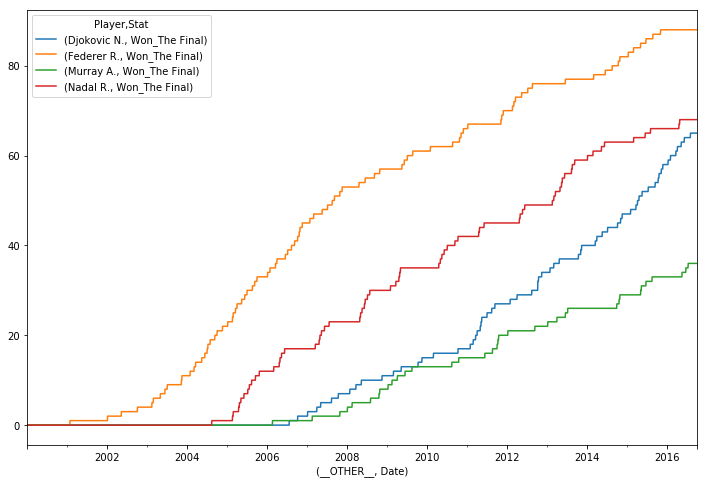

In [588]:
expanding_stats = resampled_stats.expanding().sum()
expanding_stats.sort_index(axis=1, inplace=True)
big4 = ["Nadal R.", "Federer R.", "Djokovic N.", "Murray A."]
expanding_stats.loc(axis=1)[big4, ["Won_The Final"]].plot()

#### Looking at the "dynamic" (1Y half life exponential weighted average)

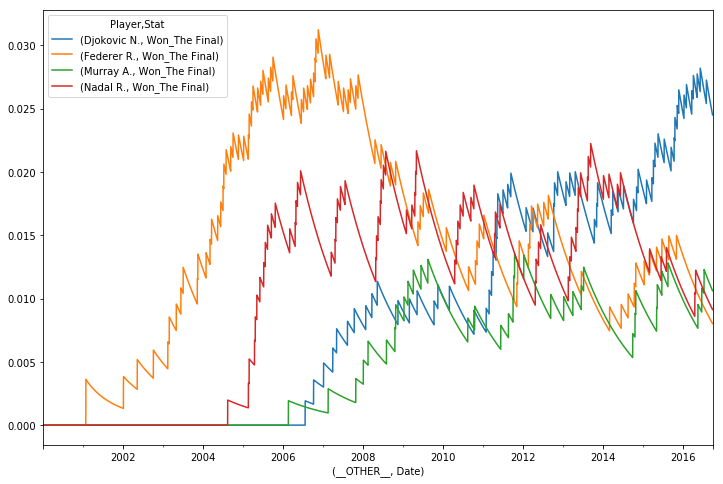

In [597]:
rolling_1Y_stats = resampled_stats.ewm(halflife=365).mean()
rolling_1Y_stats.sort_index(axis=1, inplace=True)
rolling_1Y_stats.loc(axis=1)[big4, ["Won_The Final"]].plot()

* We can clearly see that Federer has won more tournaments than any other player of the big four, but that the dynamic in the recent couple years is in favour of Djokovic
* Also we can clearly see (in both graphs) when those players started to win tournaments

## 4.C Joining that data onto the initial dataframe

Recap:
* eda_df is the initial processed dataframe (with Player1 and Player2)
* expanding_stats has the cumulative sum since the beginning of time (2000) for games played, won, 1st Round played, won etc.
* rolling_1Y_stats does an exponential moving average with a 1Y half life, looking at the 